# Imports

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
import imageio
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import BinaryCrossentropy

import warnings
import logging
warnings.simplefilter("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.autograph.set_verbosity(0)
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

## Test GPU

In [56]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

Good = 20.70 %


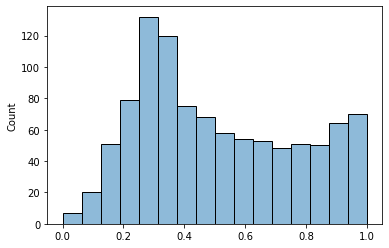

In [57]:
dimension = 2
simulation = '-m'
simulation = {'-m':'MATLAB','-r':'RTGA'}[simulation]
simmetry = 'p4'
score = 'isotropy'

if os.getcwd().split('\\')[2] == 'lucas':
    score_filename = 'E:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
    geom_epoch_dirs = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
    gif_filename = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
    tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/'
    models_dir = 'E:/Lucas GAN/Dados/5- GAN_models/%sD/%s/%s/'%(dimension,simmetry,score)
else:
    score_filename = 'D:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
    geom_epoch_dirs = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
    gif_filename = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
    tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/'
    models_dir = 'D:/Lucas GAN/Dados/5- GAN_models/%sD/%s/%s/'%(dimension,simmetry,score)

data = np.loadtxt(score_filename,delimiter=',')
X = data[:,1:-1]
size = int(np.sqrt(X.shape[1]))
X = X.reshape((X.shape[0],size,size,1))

y = data[:,-1]
y = y.reshape((y.shape[0],1))

scaler = MinMaxScaler() 
y = scaler.fit_transform(y).round(10)

# cutoff = 0.56 # p4m
cutoff = 0.78 # p4

sns.histplot(y,legend=False,bins=16)
idxs_good = np.where(y>cutoff)[0]
idxs_bad = np.where(y<=cutoff)[0]

y = np.zeros(y.shape)
y[idxs_good] = 1.0
print(f"Good = %.2f %%"%(100*len(idxs_good)/(len(idxs_good)+len(idxs_bad))))
X_good = X[idxs_good]

input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# Models definition

## Generator

In [58]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,))

    # foundation for 8x8 image
    n_nodes = 128 * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2))(in_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Reshape((size, size, 128))(out_G)
    # upsample to 16x16
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2))(out_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same')(out_G)
    out_density = Lambda(lambda x:x)(out_G)

    model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_density])
    layer = model.layers[-2].weights[0]
    return model
setup_G(input_G,output_G,size).summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_20 (Dense)            (None, 8192)              1056768   
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_10 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                         

## Discriminator

In [59]:
def style_loss():
    def custom_loss(y_true,y_pred):
        size = y_pred.shape[1]*y_pred.shape[2]
        y_pred = K.round(y_pred)
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)/size
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)/size
        mse = tf.cast((por_true-por_pred)**2,tf.float32)
        return mse
    return custom_loss

def setup_D(input_D,lr,alpha):
    in_D = Input(shape=input_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(in_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Flatten()(out_D)
    out_D = Dense(1, activation='sigmoid')(out_D)

    # compile model
    in_density = Input(shape=input_D)
    out_density = Lambda(lambda x: x)(in_density)

    opt = Adam(learning_rate=lr, beta_1=0.5)
    model = Model(
                name='Discriminator', \
                inputs=[in_D,in_density], \
                outputs=[out_D,out_density])

    model.compile(
                loss=['binary_crossentropy',style_loss()], \
                loss_weights=[1.0,alpha], \
                optimizer=opt, \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

setup_D(input_D,1e-4,0.03).summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 8, 8, 64)     640         ['input_32[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 8, 8, 64)     0           ['conv2d_31[0][0]']              
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 4, 64)     36928       ['dropout_20[0][0]']             
                                                                                      

## Setup GAN

In [60]:
def setup_GAN(G_model,D_model,alpha,lr,size):
    optimizer = Adam(learning_rate=lr, beta_1=0.5)
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    model.compile(
                loss=['binary_crossentropy',style_loss()], \
                loss_weights=[1.0,alpha], \
                optimizer=optimizer, \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

alpha = 0.03
lr = 1e-4
setup_GAN(setup_G(input_G,output_G,size),setup_D(input_D,lr,alpha),alpha,lr,size).summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 Generator (Functional)         [(None, 16, 16, 1),  1327233     ['input_34[0][0]']               
                                 (None, 16, 16, 1)]                                               
                                                                                                  
 Discriminator (Functional)     [(None, 1),          38593       ['Generator[0][0]',              
                                 (None, 16, 16, 1)]               'Generator[0][1]']              
                                                                                                

# Aux functions

## For GAN

In [61]:
def generate_fake_samples(G_model, input_G, n_samples):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples)
    # predict outputs
    X,_ = G_model.predict(X_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples):
    # generate points in the latent space
    X_input = np.random.randn(input_G * n_samples)
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(n_samples, input_G)
    return X_input

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def summarize_performance(epoch,porosity,G_model, D_model, data, input_G, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(data, n_samples)
    # evaluate discriminator on real examples
    _,_,_,acc_real,_ = D_model.evaluate(x=[X_real,X_real], y=[y_real,porosity*np.ones(X_real.shape)], verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(G_model, input_G, n_samples)
    # evaluate discriminator on fake examples
    _,_,_,acc_fake,_ = D_model.evaluate(x=[X_fake,X_fake], y=[y_fake,porosity*np.ones(X_fake.shape)], verbose=0)
    # summarize discriminator performance
    return  acc_real,acc_fake

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = 1 - np.sum(g)/(size*size)
        if p >= porosity-tol and p <= porosity+tol:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return passed/len(geoms),np.array(geoms_).reshape((passed,size,size,1))

## For geometry manipulation

In [62]:
def create_unit(element,size,simmetry):
  if simmetry[1:] == '4':
    unit_size = 2*size
    # fold_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        
        j_ = [j,w-1-i,2*h-1-j,i+w]
        i_ = [i+w,j,w-1-i,2*h-1-j]
        # (1,7)->(7,14)->(14,8)->(8,1)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el
    return unit

  if simmetry[1:] in ['4m','4g']:
    unit_element_size = 2*size
    # fold_element_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        j_ = [j,unit_size-1-j,unit_size-1-j,j]
        i_ = [i+size,i+size,size-1-i,size-1-i]
        # (1,2)-> (1,13) -> (14,13) -> (14,2)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el
    return unit

def create_arrange(unit,rows,cols):
  size = unit.shape[0]
  arrange = np.zeros((rows*size,cols*size))
  for i in range(unit.shape[0]):
    for j in range(unit.shape[1]):
      for row in range(rows):
        for col in range(cols):
          arrange[j+row*size,i+col*size] = unit[j,i]
  
  return arrange

def get_porosity(geom):
    voids = np.where(geom == 0.0)[0].shape[0]

    return voids/(geom.shape[0]**2)

# Training GAN

1/1 [==============================] - 0s 128ms/step
>1, 1/3, D_loss=0.704, G_loss=0.761
1/1 [==============================] - 0s 19ms/step
>1, 2/3, D_loss=0.695, G_loss=0.764
1/1 [==============================] - 0s 19ms/step
>1, 3/3, D_loss=0.694, G_loss=0.762
1/1 [==============================] - 0s 20ms/step
>2, 1/3, D_loss=0.706, G_loss=0.763
1/1 [==============================] - 0s 21ms/step
>2, 2/3, D_loss=0.684, G_loss=0.759
1/1 [==============================] - 0s 18ms/step
>2, 3/3, D_loss=0.694, G_loss=0.765
1/1 [==============================] - 0s 21ms/step
>3, 1/3, D_loss=0.701, G_loss=0.762
1/1 [==============================] - 0s 18ms/step
>3, 2/3, D_loss=0.693, G_loss=0.775
1/1 [==============================] - 0s 20ms/step
>3, 3/3, D_loss=0.713, G_loss=0.766
1/1 [==============================] - 0s 18ms/step
>4, 1/3, D_loss=0.706, G_loss=0.775
1/1 [==============================] - 0s 18ms/step
>4, 2/3, D_loss=0.714, G_loss=0.770
1/1 [==========================

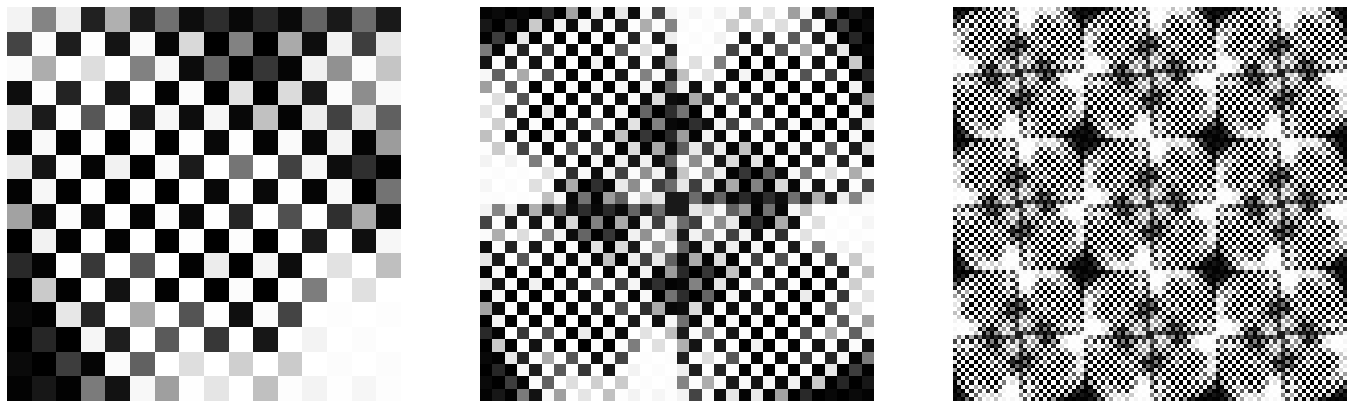

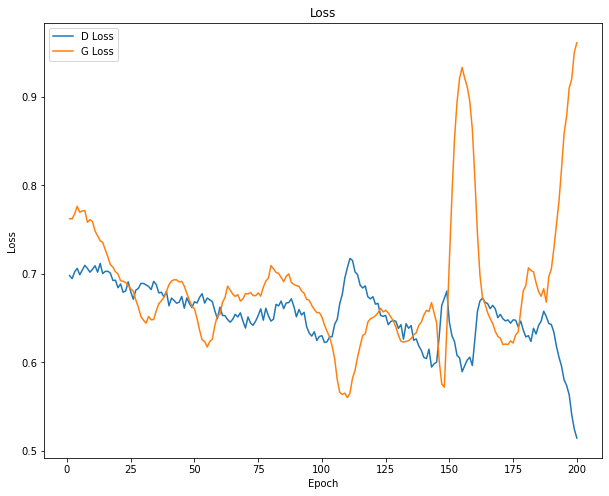

In [66]:
def train(G_model,D_model,GAN_model,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,geom_epoch_dirs,seed_geom_gif,plot=False,verbose_loss=False,verbose_acc=False):
    
    for file in os.listdir(tmp_models_dir):
        os.remove(tmp_models_dir+file)

    for geom_file in os.listdir(geom_epoch_dirs):
        os.remove(geom_epoch_dirs+geom_file)

    batch_per_epoch = int(X_good.shape[0] /batch_size)
    half_batch = int(batch_size/2)
    
    G_losses = []
    D_losses = []

    fig,ax = plt.subplots(1,3);
    fig.set_size_inches((24,8))
    for i in range(num_epochs):
        G_losses_epoch = []
        D_losses_epoch = []
        for j in range(batch_per_epoch):
            X_real,y_real = generate_real_samples(X_good,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            if not verbose_loss:
                D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)])
                D_loss = D_loss[0]
            else:
                D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)],return_dict=True)
                D_loss = D_loss['loss']

            D_losses_epoch.append(D_loss)

            X_GAN = generate_input_G(input_G, batch_size)
            y_GAN = np.ones((batch_size, 1))

            if not verbose_loss:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)])
                G_loss = G_loss[0]
            else:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)],return_dict=True)
                G_loss = G_loss['loss']

            if verbose_loss: 
                print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch,  D_loss, G_loss))
            G_losses_epoch.append(G_loss)
        

        G_losses.append(np.array(G_losses_epoch).mean())
        D_losses.append(np.array(D_losses_epoch).mean())
        
        # export model
        if (i+1) % 10 == 0:
            acc_real,acc_fake = summarize_performance(i+1,porosity,G_model,D_model,X_good,input_G)

            X_test = generate_input_G(input_G,1000)
            geoms, _ = G_model.predict(X_test)
            geoms = np.array(geoms)
            por_match, _ = porosity_match(geoms, porosity, tol_porosity)
            G_model.save(tmp_models_dir+f'epoch_{i+1}_por_{np.round(por_match,2)}_real_{np.round(acc_real,2)}_fake_{np.round(acc_fake,2)}.h5')
            
            if verbose_acc:
                print('>Epoch: %i Porosity match: %.0f%% real: %.0f%% fake: %.0f%%' % (i+1, por_match*100, acc_real*100, acc_fake*100))

        # save geometry
        if (i+1) % 5 == 0:
            geom_gif_filename = geom_epoch_dirs + 'epoch_%03d.png'%(i+1)
            elem_gif,_ = G_model.predict(seed_geom_gif)
            size = elem_gif.shape[1]
            elem_gif = elem_gif.reshape((size,size))
            ax[0].imshow(elem_gif,cmap='Greys');
            ax[0].axis('off')

            unit_gif = create_unit(elem_gif,size,'p4') 
            ax[1].imshow(unit_gif,cmap='Greys');
            ax[1].axis('off')

            arrange_gif = create_arrange(unit_gif,3,3)
            ax[2].imshow(arrange_gif,cmap='Greys');
            ax[2].axis('off')
            plt.savefig(geom_gif_filename, bbox_inches='tight')

    G_losses = np.array(G_losses)
    D_losses = np.array(D_losses)
    if plot:
        plt.figure(figsize=((10,8)))
        plt.plot(list(range(1,num_epochs+1)),D_losses,label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),G_losses,label='G Loss')
        plt.legend()
        plt.show()

batch_size = 64
num_epochs = 200
lr = 1e-4

alpha = 1e-1

porosity = 0.55
tol_porosity = 0.02

G = setup_G(input_G,output_G,size)
D = setup_D(input_D,lr,alpha)
GAN = setup_GAN(G,D,alpha,lr,size)

plot=True
verbose_loss=True
verbose_acc=True

seed_geom_gif = np.random.randn(input_G).reshape(1, input_G)

train(G,D,GAN,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,geom_epoch_dirs,seed_geom_gif,plot=plot,verbose_loss=verbose_loss,verbose_acc=verbose_acc)

## Compile gif

In [64]:
score = 'isotropy'
with imageio.get_writer(gif_filename, mode='I') as writer:
    for geom_filename in os.listdir(geom_epoch_dirs):
        image = imageio.imread(geom_epoch_dirs+geom_filename)
        writer.append_data(image)
    for i in range(30):
        image = imageio.imread(geom_epoch_dirs+geom_filename)
        writer.append_data(image)


## Evaluate `Generator`

## Test porosity

313/313 [==============================] - 1s 2ms/step
porosity match: 14.34%


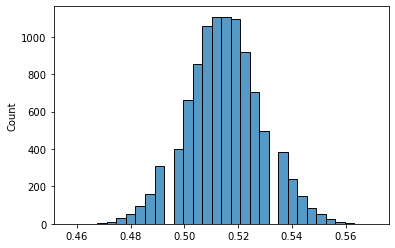

In [69]:
# select models
epoch = 200
G_files = os.listdir(tmp_models_dir)
for i in range(len(G_files)):
    G_file = G_files[i]
    if int(G_file.split('_')[1]) == epoch:
        G = load_model(tmp_models_dir+G_file)
        
test_size = 10000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G.predict(X_test)

porosities =  []
pors = []
desired_porosity = 0.55
tol = 0.02

for generated_geom in generated_geoms:
    p = generated_geom.ravel().round()
    p = 1 - p.sum()/p.shape[0]
    if p <= desired_porosity+tol and p >= desired_porosity-tol:
        pors.append(p)
    porosities.append(p)

sns.histplot(porosities,bins=32);
print(f'porosity match: {100*len(pors)/len(porosities)}%')

## Visualize geometries

In [70]:
def check_unit(unit, desired_porosity, tol):
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  passed = True

  for label in range(1,len(np.unique(labels))):
      label_count = np.where(labels==label)[0].shape[0]
      if label_count > main_label_count:
        main_label = label
        main_label_count = label_count

  void_count = 0

  for label in range(1,len(np.unique(labels))):
    if label not in [0,main_label]:
      void_count += np.where(labels==label)[0].shape[0]
      unit[np.where(labels==label)] = 0.

  porosity = get_porosity(unit)

  if porosity > desired_porosity - tol and porosity < desired_porosity + tol:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      # check if there is connectivity right-left
      connections_rl = 0
      for i in range(unit.shape[0]):
        if (unit[i,0] == 1 and unit[i,-1] == 1):
          connections_rl += 1

      # check if there is connectivity top-bottom
      connections_tb = 0
      for j in range(unit.shape[1]):
        if (unit[0,j] == 1 and unit[-1,j] == 1):
          connections_tb += 1

      if connections_rl == 0 or connections_tb == 0:
        passed = False
      
    else:
      passed = False
      
  else:
    passed = False
  return passed, unit[:unit.shape[0]//2,:unit.shape[0]//2]

def check_singularity(element, simmetry):
  passeds = [True for i in range(4)]

  # check singularities inside element
  for i in range(element.shape[0]-1):
    for j in range(element.shape[1]-1):
      # print(element[i:i+2,j:j+2])
      diag1 = list(element[i:i+2,j:j+2].diagonal())
      diag2 = list(np.fliplr(element[i:i+2,j:j+2]).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[0] = False    

  # check singularities in element boundary and singularities in unit boundary
  if simmetry[1:] == '4':
    for j in range(element.shape[1]-1):
      arr = np.array([[element[element.shape[0]-j-1,element.shape[1]-1],element[element.shape[0]-j-2,element.shape[1]-1]],[element[0,j],element[0,j+1]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[1] = False
      
      arr = np.array([[element[element.shape[0]-1,j],element[element.shape[0]-1,j+1]],[element[j,0],element[j+1,0]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[2] = False
      if [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [1, 0] or [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [0, 1]:
        passeds[3] = False

  return passeds

desired_porosity=0.55
tol = 0.02
simmetry = 'p4'
_, geometries = porosity_match(generated_geoms, desired_porosity, tol)
size = geometries.shape[1]
elements = []

for i in range(len(geometries)):
  geom = geometries[i].reshape((size,size)).round()
  unit = create_unit(geom,size,simmetry)
  passed1,element = check_unit(unit, desired_porosity, tol)
  passed2 = check_singularity(element, simmetry)
  if passed1 and all(passed2):
    elements.append(element)

geometries = np.array(elements)

# Get scores
top = 50
scores = D.predict([geometries,geometries])[0].ravel()
top_idxs = np.argsort(-scores)[:top]
for top_idx in top_idxs:
  elem = geometries[top_idx]
  unit = create_unit(elem.reshape((size,size)),size,simmetry)
  arrange = create_arrange(unit,3,3)
  
  print("Score: %.2f Porosity: %.2f"%(scores[top_idx],get_porosity(elem)))
  
  fig,ax = plt.subplots(1,3);
  fig.set_size_inches((15,5))
  
  ax[0].imshow(elem,cmap='Greys');
  ax[0].axis('off')
  
  ax[1].imshow(unit,cmap="Greys")
  ax[1].axis('off')

  ax[2].imshow(arrange,cmap="Greys")
  ax[2].axis('off')
  plt.show()

sns.histplot(1-np.sum(generated_geoms.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size),bins=32);

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.